In [17]:
import warnings
warnings.filterwarnings('ignore')

import os
from dotenv import load_dotenv

load_dotenv()
HF_API_TOKEN = os.getenv('HF_API_TOKEN')


Instead of using the In Memory Document Stoe, here we use ElasticSearch document store. It is running locally through Docker. To install ElasticSearch locally referes to this link --> (https://docs.haystack.deepset.ai/docs/elasticsearch-document-store)

In [18]:
from haystack_integrations.document_stores.elasticsearch import ElasticsearchDocumentStore
from haystack.document_stores.types import DuplicatePolicy


from haystack import Document
document_store = ElasticsearchDocumentStore(hosts = "http://localhost:9200")


In [19]:
from haystack import Pipeline

In [20]:
from haystack.components.converters.txt import TextFileToDocument
from haystack.components.preprocessors.document_splitter import DocumentSplitter
from haystack.components.embedders import SentenceTransformersDocumentEmbedder 
from haystack.components.writers import DocumentWriter

In [21]:
converter = TextFileToDocument()
splitter = DocumentSplitter(split_by='sentence', split_length=1)
embedder = SentenceTransformersDocumentEmbedder("sentence-transformers/all-MiniLM-L6-v2")
writer = DocumentWriter(document_store=document_store, policy=DuplicatePolicy.OVERWRITE)

indexing_pipeline = Pipeline()

indexing_pipeline.add_component("converter", converter)
indexing_pipeline.add_component("splitter", splitter)
indexing_pipeline.add_component("embedder", embedder)
indexing_pipeline.add_component("writer", writer)

In [22]:
indexing_pipeline.connect("converter.documents", "splitter.documents")
indexing_pipeline.connect("splitter.documents", "embedder.documents")
indexing_pipeline.connect("embedder.documents", "writer.documents")

🚅 Components
  - converter: TextFileToDocument
  - splitter: DocumentSplitter
  - embedder: SentenceTransformersDocumentEmbedder
  - writer: DocumentWriter
🛤️ Connections
  - converter.documents -> splitter.documents (List[Document])
  - splitter.documents -> embedder.documents (List[Document])
  - embedder.documents -> writer.documents (List[Document])

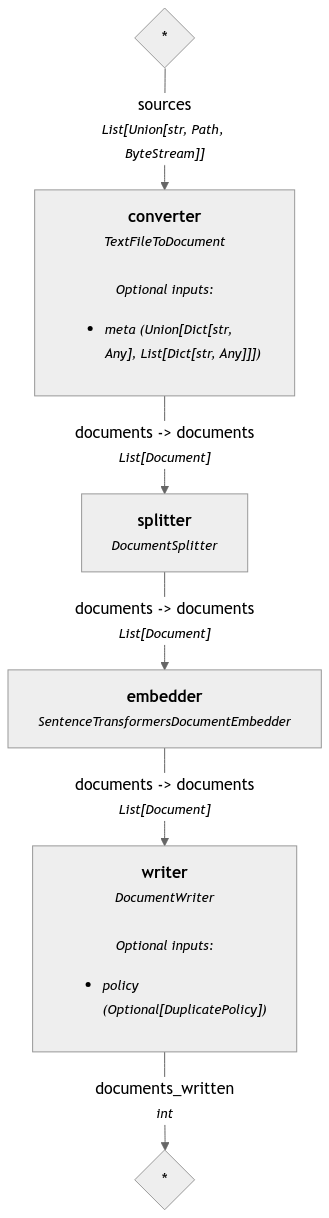

In [23]:
indexing_pipeline.show()

In [24]:
indexing_pipeline.run({"converter": {"sources": ['data/tolkien.txt']}})

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches: 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


{'writer': {'documents_written': 55}}

In [25]:
document_store.filter_documents()[0]

Document(id=41adfcdd6346f3f115b5a7f4a64833d1a55557e467077bc34acb3ee2166a0c9d, content: 'John Ronald Reuel Tolkien, born on January 3, 1892, in Bloemfontein, South Africa, is widely regarde...', meta: {'file_path': 'data/tolkien.txt', 'source_id': 'c4d35e2d2f05046acfb4acec088ffc4e6e7cddad980d9f1a4feb9a9683ef9e06', 'page_number': 1, 'split_id': 0, 'split_idx_start': 0}, score: 1.0, embedding: vector of size 384)

In [11]:
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack_integrations.components.retrievers.elasticsearch import ElasticsearchEmbeddingRetriever

query_embedder = SentenceTransformersTextEmbedder("sentence-transformers/all-MiniLM-L6-v2")
retriever = ElasticsearchEmbeddingRetriever(document_store=document_store)

document_search_embedding = Pipeline()

document_search_embedding.add_component("query_embedder", query_embedder)
document_search_embedding.add_component("retriever", retriever)

document_search_embedding.connect("query_embedder.embedding", "retriever.query_embedding")

🚅 Components
  - query_embedder: SentenceTransformersTextEmbedder
  - retriever: ElasticsearchEmbeddingRetriever
🛤️ Connections
  - query_embedder.embedding -> retriever.query_embedding (List[float])

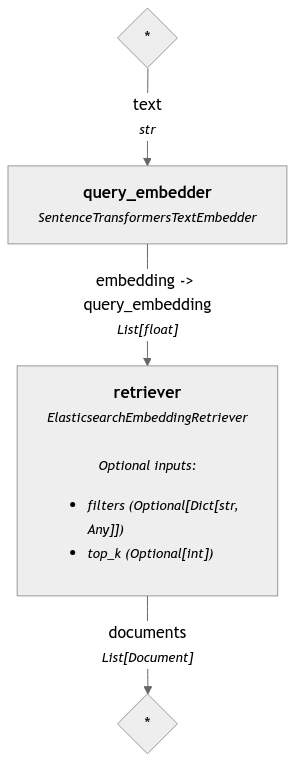

In [12]:
document_search_embedding.show()

In [13]:
question = "Where J.R.R. was born?"

results = document_search_embedding.run({"query_embedder": {"text": question},
                               "retriever": {"top_k": 3}}) #as default are 10

for i, document in enumerate(results["retriever"]["documents"]):
    print("\n--------------\n")
    print(f"DOCUMENT {i}")
    print(document.content)

Batches: 100%|██████████| 1/1 [00:00<00:00, 35.72it/s]


--------------

DOCUMENT 0
John Ronald Reuel Tolkien, born on January 3, 1892, in Bloemfontein, South Africa, stands as one of the most revered figures in the realm of literature, particularly in the genre of high fantasy.

--------------

DOCUMENT 1
 He displayed an exceptional talent for languages from a young age, inventing his own languages and scripts as a child.

--------------

DOCUMENT 2
 He graduated in 1915, but his academic pursuits were temporarily interrupted when he enlisted in the British Army during World War I.


### Esempio con BM25Retriever

In [14]:
from haystack_integrations.components.retrievers.elasticsearch import ElasticsearchBM25Retriever
retriever = ElasticsearchBM25Retriever(document_store=document_store, top_k=3)

results = retriever.run(query="What languages he developed?")
for document in results['documents']:
    print(document.content)


 The languages he developed, such as Elvish (Quenya and Sindarin), are linguistically rich and demonstrate his expertise as a philologist.
 He displayed an exceptional talent for languages from a young age, inventing his own languages and scripts as a child.
 He created an intricate mythology complete with detailed histories, languages, and cultures.


### BONUS

In the previous examples we added a document to the document store that we already had in our folders.
But Hyastack allows you to directly fetch documents from URLs. Let's see how!

In [15]:
from haystack import Pipeline
from haystack.utils import Secret

from haystack.components.fetchers import LinkContentFetcher
from haystack.components.converters import HTMLToDocument
from haystack.components.preprocessors import DocumentSplitter
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack.components.writers import DocumentWriter

In [16]:
from haystack_integrations.document_stores.qdrant import QdrantDocumentStore

QDRANT_API_TOKEN = os.getenv('QDRANT_API_TOKEN')

In [4]:
document_store = QdrantDocumentStore(
		url="https://54219cf9-57be-49fd-bda4-936864596118.europe-west3-0.gcp.cloud.qdrant.io:6333",
    api_key= Secret.from_token(QDRANT_API_TOKEN),
    embedding_dim = 384
)

In [92]:
#document_store.recreate_collection(collection_name="Document", embedding_dim=384, distance="Cosine")

In [5]:
document_store.count_documents()

34

In [6]:
document_store.filter_documents()[0].meta

{'content_type': 'text/html',
 'url': 'https://docs.haystack.deepset.ai/docs/components',
 'source_id': 'ff981490b8faee1d70ef840ee838defa8253340ef2b9aa81853b4fd28f631a95',
 'page_number': 1,
 'split_id': 21,
 'split_idx_start': 2242,
 '_split_overlap': [{'doc_id': '75aa93fb2d208217d1ea88ace3329e31678cc0fe3d43472afe276004fa7bff5f',
   'range': [28, 65]},
  {'doc_id': '50f171dd8e14af22160e3b01a43cbe9f3f093a91efeb9c2c764e613af10b1038',
   'range': [0, 77]}]}

**content_type**: Specifies the type of content, which here is 'text/html'. This indicates the document is in HTML format.

**url**: The URL where the document is located. This points to the original source of the data, which in this case is a Haystack documentation page.

**source_id**: A unique identifier for the source document, in the form of a hashed value. This ID is used by Haystack to keep track of the original document.

**page_number**: Indicates the page number from which this specific content was extracted. In this case, it's page 1, which could relate to either the webpage or a PDF page.

**split_id**: An identifier for the specific text split. Haystack divides larger documents into manageable segments, and each segment has its own split_id for easy referencing.

**split_idx_start**: Denotes the character index in the document where this specific segment begins, allowing you to pinpoint the exact starting position of the split within the original content.

**_split_overlap**: A list indicating any overlap of this split with other segments, identified by doc_id. The range field gives the start and end indices of overlapping content within each document. This ensures smooth reading flow between splits, especially for long documents.

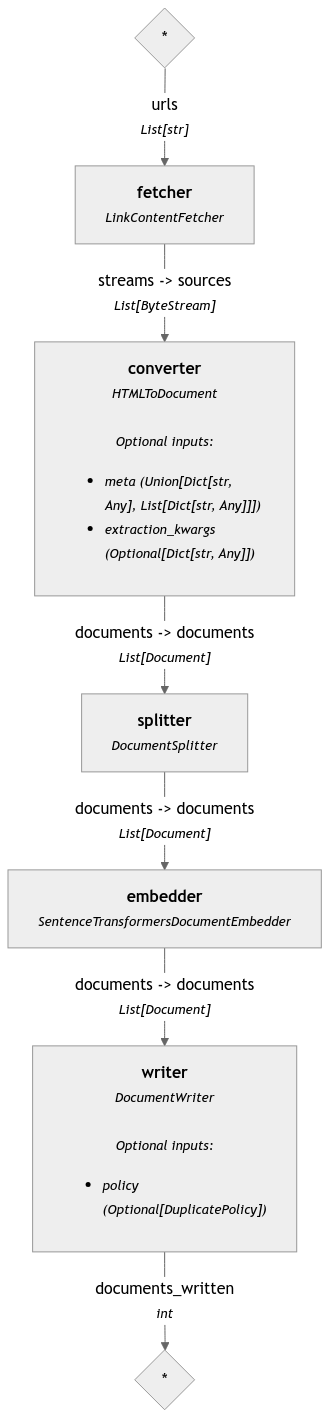

In [94]:
indexing = Pipeline()
indexing.add_component("fetcher", LinkContentFetcher()) #this component allow us to fetch documents from a URL
indexing.add_component("converter", HTMLToDocument()) #This convert the content of an HTML page to a Document
indexing.add_component("splitter", DocumentSplitter(split_by="sentence", split_length=2, split_overlap = 1)) # The split_overlap value allows for overlapping sections when dividing the text into chunks.
indexing.add_component("embedder", SentenceTransformersDocumentEmbedder("sentence-transformers/all-MiniLM-L6-v2"))
indexing.add_component("writer", DocumentWriter(document_store))


indexing.connect("fetcher", "converter")
indexing.connect("converter", "splitter")
indexing.connect("splitter", "embedder")
indexing.connect("embedder", "writer")

url = ["https://docs.haystack.deepset.ai/docs/components"]

indexing.show()

In [95]:
indexing.run(data={"fetcher": {"urls": url}})

Batches: 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]
100it [00:00, 153.05it/s]             


{'writer': {'documents_written': 34}}

In [96]:
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack_integrations.components.retrievers.qdrant import QdrantEmbeddingRetriever

query_embedder = SentenceTransformersTextEmbedder("sentence-transformers/all-MiniLM-L6-v2")
retriever = QdrantEmbeddingRetriever(document_store=document_store)

document_search = Pipeline()

document_search.add_component("query_embedder", query_embedder)
document_search.add_component("retriever", retriever)

document_search.connect("query_embedder.embedding", "retriever.query_embedding")

🚅 Components
  - query_embedder: SentenceTransformersTextEmbedder
  - retriever: QdrantEmbeddingRetriever
🛤️ Connections
  - query_embedder.embedding -> retriever.query_embedding (List[float])

In [97]:
question = "What is a component?"

results = document_search.run({"query_embedder": {"text": question},
                               "retriever": {"top_k": 3}}) #as default are 10

for i, document in enumerate(results["retriever"]["documents"]):
    print("\n--------------\n")
    print(f"DOCUMENT {i}")
    print(document.content)

Batches: 100%|██████████| 1/1 [00:00<00:00,  5.69it/s]



--------------

DOCUMENT 0
Components
Components are the building blocks of a pipeline. They perform tasks such as preprocessing, retrieving, or summarizing text while routing queries through different branches of a pipeline.

--------------

DOCUMENT 1

Components are connected to each other using a pipeline, and they function like building blocks that can be easily switched out for each other. A component can take the selected outputs of other components as input.

--------------

DOCUMENT 2
 This page is a summary of all component types available in Haystack.
Components are connected to each other using a pipeline, and they function like building blocks that can be easily switched out for each other.
